# Übungszettel 4: Eigenfaces, Clustering (Musterlösung)

## Maschinelles Lernen - WiSe 23/24

### Abgabe 15.11.2023, 23:55 Uhr

*Hinweise:*
- Übungsaufgaben **müssen** in Gruppen von 3-4 Personen abgegeben werden. **Einzelabgaben werden nicht korrigiert bzw. bewertet.**
- Es wird pro Übungszettel nur eine Aufgabe bewertet, die übrigen Aufgaben dienen zur selbstständigen Vertiefung des Vorlesungsstoffs. Für diese Aufgaben werden nach der Abgabe Musterlösungen bereitgestellt.
- Die Lösungen sollen in diesem IPython Notebook realisiert werden, wobei Teilaufgaben und Zwischenergebnisse ausgegeben bzw. visualisiert werden sollen.
- Für die Abgabe sollen Sie dieses IPython Notebook und ggf. zugehörige Dateien in ein **Ziparchiv** packen und im Ilias hochladen. Das Ziparchiv soll nach folgendem Muster benannt werden:
`UebungXX_Nachname1_Nachname2_Nachname3.zip`, wobei die Nachnamen in alphabetischer Reihenfolge angegeben und Umlaute ggf. ersetzt werden sollen.

---

## Aufgabe 1 - Eigenfaces

In dieser Aufgabe beschäftigen wir uns mit der Hauptkomponentenanalyse (Principal Component Analysis, PCA) am Beispiel von *Eigenfaces*. Dieses ist ein frühes Verfahren zur automatisierten Gesichtserkennung. Als Datensatz für die Gesichtserkennung wird Labeled Faces in the Wild (LFW) verwendet (http://vis-www.cs.umass.edu/fddb/).

In *Eigenfaces* werden die Bilder von Gesichtern kompakt repräsentiert durch die wichtigsten Hauptkomponenten als Basisvektoren. Um ein unbekanntes Gesicht zu klassifizieren, wird dieses in den durch die Eigenfaces (Eigenvektoren) erzeugten Eigenraum projiziert. Dann kann der Abstand (z.B. Euklidischer Abstand) zu den Bildern in der Datenbank gemessen werden und z.B. mittels Nearest-Neighbor-Suche klassifiziert werden. 

In [2]:
# For installing sklearn uncomment the following line:
# !pip install sklearn
from sklearn.datasets import fetch_lfw_people
lfw = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

images = lfw['images']       # Faces as grayscale images
names = lfw['target_names']  # images as 

X = lfw.data   # Faces as vectors
y = lfw.target # Labels

a) Geben Sie die Anzahl der Personen, die Gesamtzahl von Bildern, die Abmessungen der Bilder und die Anzahl von Features (in diesem Fall Pixel) pro Bild aus. Visualisieren Sie ein zufälliges Gesicht aus LFW zusammen mit dem dazugehörigen Namen.

Anzahl Personen:   7
Anzahl Features:   1850
Anzahl Bilder:     1288
Größe Bilder:      50x37


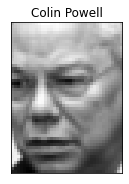

In [3]:
import numpy as np
from matplotlib import pyplot as plt
random_id = np.random.randint(0,len(images))

image_shape = images[0].shape
n_persons = len(names)
n_features = len(X[0])
n_images = len(X)

print("Anzahl Personen:   %d" % n_persons)
print("Anzahl Features:   %d" % n_features)
print("Anzahl Bilder:     %d" % n_images)
print("Größe Bilder:      %dx%d" % image_shape)

face = images[random_id]
name = names[y[random_id]]
plt.figure(figsize=(2,4))
plt.imshow(face, cmap="gray")
plt.xticks(())
plt.yticks(())
plt.title(name)
plt.show()

b) Teilen Sie den Datensatz in Training- und Testdatensatz. Der Testdatensatz soll jeweils 10% der Bilder einer Person enthalten, der Trainingsdatensatz die restlichen Bilder. Nutzen Sie hierzu eine Methode aus `sklearn`.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

c) Berechnen Sie das Mean Bild auf den Trainingsdaten und visualisieren Sie es.  

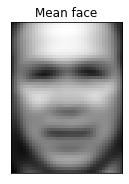

In [5]:
X_train_mean = np.mean(X_train,axis=0).reshape(1,n_features)
train_mean_face = X_train_mean.reshape(image_shape)
plt.figure(figsize=(2,4))
plt.imshow(train_mean_face, cmap="gray")
plt.title("Mean face")
plt.xticks(())
plt.yticks(())
plt.show()

d) Schreiben Sie eine Methode `pca` die als Eingabe `dataset`, eine Menge von Eingabe-Vektoren, und `q` die Anzahl der Eigenvektoren erhält. Führen Sie in der Methode dann eine PCA auf den Eingabedaten durch und liefern Sie ein Tupel zurück mit folgendem Inhalt:

* Projektionsmatrix (Eigenvektoren mit gen größten Eigenwerten) mit Shape (q, #Anzahl Features)
* q Eigenwerte absteigend sortiert

Gehen Sie wie folgt vor:

1. Standardisieren Sie alle Features 
2. Berechnen Sie die Kovarianzmatrix
3. Bestimmen Sie die Eigenwerte und Eigenvektoren (*Tipp:* Nutzen Sie eine Methode für symmetrische Matrizen)
4. Konstruieren Sie die Projektionsmatrix aus den q Eigenvektoren mit den größten Eigenwerten

Für diese Methode sollen nur Methoden aus `numpy` benutzt werden.

In [6]:
def pca(dataset, q=10):
    # Standardisierung
    mean = np.mean(dataset, axis=0)    
    sigma = np.std(dataset, axis=0)
    x = (dataset - mean) / sigma
    # Kovarianzmatrix
    cov_mat= np.cov(x.T)
    # Eigenwerte und Eigenvektoren
    (eigenvals, w) = np.linalg.eigh(cov_mat)
    # Projektionsmatrix aus den q Eigenvektoren mit den größten Eigenwerten
    eigenval_index = np.argsort(eigenvals)[::-1]
    p = w[:, eigenval_index[0:q]]
    return p.T, eigenvals[eigenval_index[0:q]]

eigenfaces, eigenvals = pca(X_train, q=100)

e) Extrahieren Sie die ersten 100 Eigenfaces (Eigenvektoren) aus dem Trainingsdatensatz mittels PCA. Visualisieren Sie die ersten 20 Eigenfaces.

Extracting first 100 eigenfaces from 1159 faces...
Finished in 2.312s


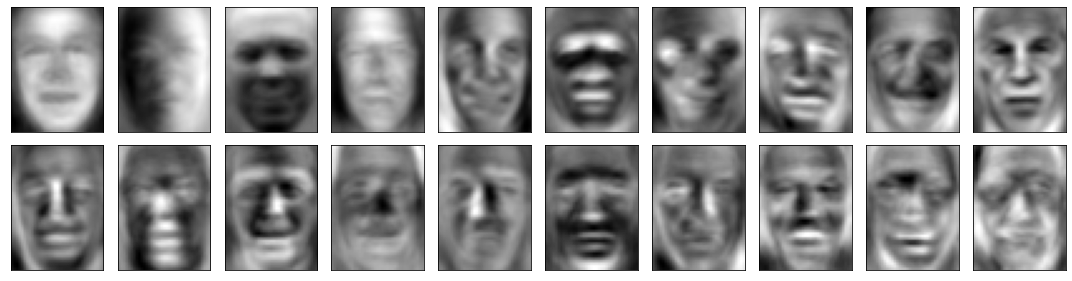

In [7]:
from time import time

n_eigenfaces = 100
print("Extracting first %d eigenfaces from %d faces..." % (n_eigenfaces, len(X_train)))
start = time()
eigenfaces, eigenvals = pca(X_train, q=100)
print("Finished in %0.3fs" % (time() - start))

n_row=2
n_col=10

plt.figure(figsize=(1.5 * n_col, 2.2 * n_row))
plt.subplots_adjust(0.6, 0.5, 1.5, 1.5)
for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(eigenfaces[i].reshape(image_shape), cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()
plt.show()

f) Plotten Sie die ersten 50 (normalisierten) Eigenwerte als Balkendiagramm. Visualisieren Sie auch die kumulativen Varianzen der Hauptkomponenten.
Wählen Sie basierend auf dieser Visualisierung die Anzahl `n_pcs` der Hauptkomponenten, die Sie für die Repräsentation der Gesichter nutzen möchten. Begründen Sie Ihre Entscheidung.

<AxesSubplot:>

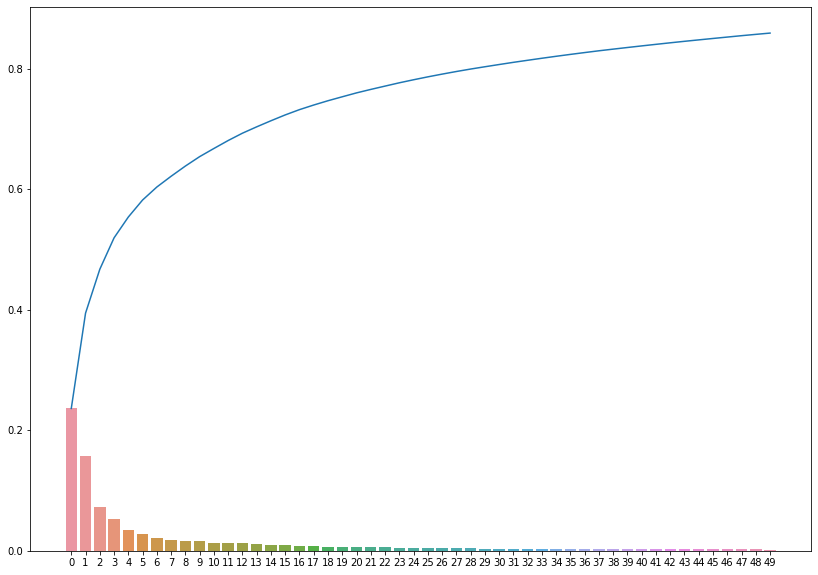

In [8]:
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = (14,10)
n = 50
sns.barplot(x=list(range(0,n)), y=eigenvals[:n]/n_features)
sns.lineplot(x=list(range(0,n)),y=np.cumsum(eigenvals[:n])/n_features)

g) Nutzen Sie die Projektionsmatrix, die Sie mit der `pca` Methode aus Aufgabenteil d) erhalten haben um den Testdatensatz in einen Raum mit niedrigerer Dimension zu projezieren. Dazu multiplizieren Sie die Projektionsmatrix mit dem Testdatensatz. Visualisieren Sie dann 5 zufällige rekonstruierte Gesichter aus dem Testdatensatz. Für die Rekonstruktion multiplizieren Sie die PCA-transformierten Daten mit der Projektionsmatrix.

Nutzen Sie als Projektionsmatrix jeweils:
* die ersten 4 Eigenvektoren
* die ersten `n_pcs` Eigenvektoren
* alle 100 Eigenvektoren (also die komplette Projektionsmatrix)

<Figure size 1008x720 with 0 Axes>

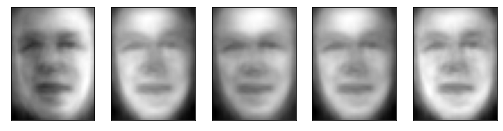

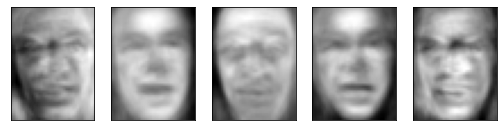

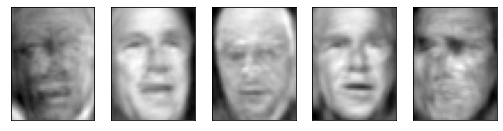

In [9]:
n = 5

n_col = 5
n_row = 1

def project_and_reconstruct(q, face_ids):
    plt.figure(figsize=(1.5 * n_col, 2.2 * n_row))
    plt.subplots_adjust(0.6, 0.5, 1.5, 1.5)
    X_test_pca = np.matmul(eigenfaces[:q],X_test.T).T
    X_test_rec = np.matmul(X_test_pca, eigenfaces[:q])
    random_faces = X_test_rec[random_face_ids]
    for i, face in enumerate(random_faces):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(face.reshape(image_shape), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
plt.tight_layout()
plt.show()

random_face_ids = np.random.randint(0, len(X_test), n)

project_and_reconstruct(4,random_face_ids)
project_and_reconstruct(25,random_face_ids)
project_and_reconstruct(100,random_face_ids)

h) Nun sollen die Bilder aus dem Testdatensatz klassifiziert werden. Gehen Sie dazu wie folgt vor: Transformieren Sie sowohl die Test- als auch die Trainingsdaten, indem Sie die vollständige Projektionsmatrix aus Aufgabenteil d) nutzen. Wählen Sie dann 3 zufällige Vektoren aus dem transformierten Testdatensatz. Berechnen Sie die euklidische Distanz zu allen Vektoren im Trainingsdatensatz.
Visualisieren Sie dann das jeweilige Gesicht und geben Sie jeweils die zugehörigen Namen der 5 nächsten Nachbarn zusammen mit der Distanz aus.

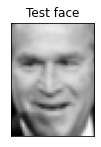

Nearest neighbors: 
1176.031 	 George W Bush
1236.114 	 Tony Blair
1244.919 	 Tony Blair
1260.422 	 Tony Blair
1312.683 	 Colin Powell


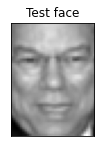

Nearest neighbors: 
697.478 	 Colin Powell
739.329 	 Colin Powell
787.663 	 Colin Powell
801.575 	 George W Bush
866.657 	 Colin Powell


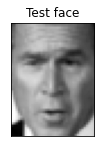

Nearest neighbors: 
1164.343 	 George W Bush
1177.854 	 George W Bush
1223.498 	 George W Bush
1352.628 	 George W Bush
1377.286 	 Colin Powell


In [10]:
X_test_pca = np.matmul(eigenfaces,X_test.T).T
X_train_pca = np.matmul(eigenfaces,X_train.T).T

n = 3
random_ids = np.random.randint(0, len(X_test), n)

for i in random_ids: 
    plt.figure(figsize=(1.5, 2.2))
    plt.imshow(X_test[i].reshape(image_shape), cmap="gray")
    plt.title("Test face")
    plt.xticks(())
    plt.yticks(())
    plt.show()
    query = X_test_pca[i]
    dists = [ np.linalg.norm(query-x) for x in X_train_pca ]
    predicted_names = [ names[cls] for cls in y_train ]
    dists_with_names = zip(dists, predicted_names)
    dists_with_names = sorted(dists_with_names)
    print("Nearest neighbors: ")
    for dist, name in dists_with_names[:5]:
        print("%.3f \t %s" % (dist, name))

i) Bei der Klassifizierung in Aufgabenteil h) treten häufig Fehler auf. Woran könnte das liegen?

Damit Eigenfaces gut funktioniert,  ist ein sehr hohes Maß an Homogenität in Bezug auf Lichtverhältnisse, Größe der Bilder, Rotation und Skalierung des Gesichts notwendig. Die Gesichter im Datensatz Labeled Faces in the Wild sind jedoch nicht normalisiert (Face Alignment), d.h. wenn ein Gesicht in unterschiedlichen Perspektiven etc. vorkommt, ändert sich auch die Position charakteristischer Punkte (Augen, Nase etc.).

---
## Aufgabe 2 - K-Means

a) Wenden Sie in diesem Aufgabenteil das K-Means-Verfahren von Hand an. Es sind folgende Datenpunkte im euklidischen Raum gegeben:

| Punkt   | X     | Y     |
| :------ |------:|------:| 
| A       | 1.2   | 0.8   |
| B       | -0.6  | -1.3  |
| C       | -0.8  | 0.2   |
| D       | 0.2   | 0.3   |

Punkt A und C werden initial zu den Clusterzentroid C1, Punkte B und D initial zu den Clusterzentroid C2
zugeordnet.

Ermitteln sie die Minimal-Distanz-Partition unter der Anwendung des K-Means-Verfahrens und der euklidischen Distanz. Starten Sie, in dem Sie erst die jeweiligen Clusterschwerpunkte ermitteln.

### Iteration 1:
$$
1 \rightarrow {A,C} \\
2 \rightarrow {B,D}
$$

$$
C_1= \left(\begin{array}{rr} 
\dfrac {x_A + x_C}{2} \\ 
\dfrac {y_A + y_C}{2} \\ 
\end{array}\right) = \left(\begin{array}{rr} 
                               0,2 \\ 
                                0,5\\ 
                            \end{array}\right)
$$

$$
C_2= \left(\begin{array}{rr} 
\dfrac {x_B + x_D}{2} \\ 
\dfrac {y_B + y_D}{2} \\ 
\end{array}\right) = \left(\begin{array}{rr} 
                               -0,2 \\ 
                                -0,5\\ 
                            \end{array}\right)
$$

$$
\|A - C_1\|_2 = \sqrt{(1,2 - 0,2)^2 + (0,8 - 0,5)^2} = \pmb{1.04} \\
\|A - C_2\|_2 = \sqrt{(1,2 + 0,2)^2 + (0,8 + 0,5)^2} = 1.91 \\
$$

$$
\|B - C_1\|_2 = \sqrt{(-0,6 - 0,2)^2 + (-1,3 - 0,5)^2} = 1,96 \\
\|B - C_2\|_2 = \sqrt{(-0,6 + 0,2)^2 + (-1,3 + 0,5)^2} = \pmb{0,89} \\
$$

$$
\|C - C_1\|_2 = \sqrt{(-0,8 - 0,2)^2 + (0.2 - 0,5)^2} = 1,04 \\
\|C - C_2\|_2 = \sqrt{(-0,8 + 0,2)^2 + (0.2 + 0,5)^2} = \pmb{0,92} \\
$$

$$
\|D - C_1\|_2 = \sqrt{(0,2 - 0,2)^2 + (0.3 - 0,5)^2} = \pmb{0.2} \\
\|D - C_2\|_2 = \sqrt{(0,2 + 0,2)^2 + (0.3 + 0,5)^2} = 0.89 \\
$$

### Iteration 2:

$$
1 \rightarrow {A,D} \\
2 \rightarrow {B,C}
$$


$$
C_1= \left(\begin{array}{rr} 
\dfrac {x_A + x_D}{2} \\ 
\dfrac {y_A + y_D}{2} \\ 
\end{array}\right) = \left(\begin{array}{rr} 
                               0,7 \\ 
                                0,55\\ 
                            \end{array}\right)
$$

$$
C_2= \left(\begin{array}{rr} 
\dfrac {x_B + x_C}{2} \\ 
\dfrac {y_B + y_C}{2} \\ 
\end{array}\right) = \left(\begin{array}{rr} 
                               -0,7 \\ 
                                -0,55\\ 
                            \end{array}\right)
$$



$$
\|A - C_1\|_2 = \sqrt{(1,2 - 0,7)^2 + (0,8 - 0,55)^2} = \pmb{0,55} \\
\|A - C_2\|_2 = \sqrt{(1,2 + 0,7)^2 + (0,8 + 0,55)^2} = 2,33 \\
$$

$$
\|B - C_1\|_2 = \sqrt{(-0,6 - 0,7)^2 + (-1,3 - 0,55)^2} = 2,26 \\
\|B - C_2\|_2 = \sqrt{(-0,6 + 0,7)^2 + (-1,3 + 0,55)^2} = \pmb{0,75} \\
$$

$$
\|C - C_1\|_2 = \sqrt{(-0,8 - 0,7)^2 + (0.2 - 0,55)^2} = 1,54 \\
\|C - C_2\|_2 = \sqrt{(-0,8 + 0,7)^2 + (0.2 + 0,55)^2} = \pmb{0,75} \\
$$

$$
\|D - C_1\|_2 = \sqrt{(0,2 - 0,7)^2 + (0.3 - 0,55)^2} = \pmb{0,55} \\
\|D - C_2\|_2 = \sqrt{(0,2 + 0,7)^2 + (0.3 + 0,55)^2} = 1,23 \\
$$


### Abbruchbedingung erfüllt:
weitere Iterationen sind nicht nötig, da sich bei den Zuordnungen nichts mehr ändert:

$$
1 \rightarrow {A,D} \\
2 \rightarrow {B,C}
$$

$$
C_1= \left(\begin{array}{rr} 
               0,7 \\ 
                0,55\\ 
    \end{array}\right)
$$



$$
C_2= \left(\begin{array}{rr} 
               -0,7 \\ 
                -0,55\\ 
    \end{array}\right)
$$




In [1]:
import numpy as np

In [2]:
def k_means(samples, clusters):
    means = np.asarray([samples[idx].mean(axis=0) for idx in clusters])
    ds = np.asarray([np.linalg.norm(mean - samples, axis=1) for mean in means])
    argmins = np.argmin(ds.T, axis=1)
    new_clusters = np.asarray([np.where(argmins == i)[0] for i in range(len(clusters))])
    if np.array_equal(new_clusters, clusters):
        return clusters, means 
    else:
        return k_means(samples, new_clusters)

samples = np.array([[1.2, 0.8],[-0.6, -1.3],[-0.8, 0.2],[0.2, 0.3]])
clusters = [[0, 2], [1, 3]]
min_clusters, means = k_means(samples, clusters)
print("Min. clustering:\n{}\n".format(samples[min_clusters,:]))
print("Means:\n{}".format(means))

Min. clustering:
[[[ 1.2  0.8]
  [ 0.2  0.3]]

 [[-0.6 -1.3]
  [-0.8  0.2]]]

Means:
[[ 0.7   0.55]
 [-0.7  -0.55]]


b) Beschreiben Sie kurz wofür Silhouetten berechnet werden. 

Silhouetten werden berechnet, um zu bestimmen, ob ein Objekt seinem aktuellen Cluster *A* oder dem nächstgelegenen Cluster *B* näher ist.

c) Was bedeuten negative Werte und was gibt der Silhouetten Koeffizient an? 

Der Silhouettenkoeffizient ist der Mittelwert der Silhouetten aller Objekte eines Clusters. Anhand dieses Koeffizienten lässt sich ablesen, wie gut die Zuordnung zu den *k* Clustern ist. Je höher der Wert, desto besser funktioniert die Aufteilung in *k* Cluster.
Ein negativer Wert bedeutet, dass die jeweiligen Objekte im Schnitt eine geringere Distanz zum nächsten Nachbarcluster *B* als zum eigenen Cluster *A* haben.

d) Berechnen Sie den Silhouetten Koeffizienten für die Cluster aus Aufgabenteil a) von Hand. 

#### Cluster 1:
Punkt A:
$$
\begin{align}
a(A) &= \dfrac{1}{|CL_1| -1 } \sum_{j \in CL_1, j \neq A} d(A,j) \\
     &=  1 \cdot d(A,D) \\
     &=  \| A-D \|_2  \\
     &=   \sqrt{(1,2 - 0,2)^2 + (0,8 - 0,3)^2}\\ 
     &=  1,11 \\
b(A) &= \min_{k\neq 1} \dfrac{1}{CL_k} \sum_{j \in CL_k} d(A,j)\\
      &=  \dfrac{1}{2} ( d(A,B) + d(A,C)) \\
      &= \dfrac{1}{2} ( \sqrt{(1,2 + 0,6)^2 + (0,8 + 1,3)^2} + \sqrt{(1,2 + 0,8)^2 + (0,8 - 0,2)^2}) \\
      &= 2,42 \\
s(A) &= \dfrac{a(A) - b(A)}{\max\{a(A), b(A)\}} =  0,54
\end{align}
$$

Punkt D:
$$
\begin{align}
a(D) &= \dfrac{1}{|CL_1| -1 } \sum_{j \in CL_1, j \neq D} d(D,j) \\
     &=  1 \cdot d(D,A) \\
     &=  d(A,D)  \\
     &=  1,11 \\
b(D) &= \min_{k\neq 1} \dfrac{1}{CL_k} \sum_{j \in CL_k} d(D,j)\\
      &=  \dfrac{1}{2} (d(D,B) + d(D,C)) \\
      &= \dfrac{1}{2} ( \sqrt{(0,2 + 0,6)^2 + (0,3 + 1,3)^2} + \sqrt{(0,2 + 0,8)^2 + (0,3 - 0,2)^2}) \\
      &= 1,39 \\
s(D) &= \dfrac{a(D) - b(D)}{\max\{a(D), b(D)\}} =  0.2\\
\end{align}
$$

Silhouetten Koeffizient für Cluster 1: 

$$
s(CL_1) = \dfrac{s(A)+s(D)}{2} = \dfrac{0,54+0,2}{2} = \pmb{0,37} 
$$

#### Cluster 2:
Punkt B: 

$$
\begin{align}
a(B) &= \dfrac{1}{|CL_2| -1 } \sum_{j \in CL_2, j \neq B} d(B,j) \\
     &=  1 \cdot d(B,C) \\
     &=  \| B-C \|_2  \\
     &=   \sqrt{(-0,6 + 0,8)^2 + (-1,3 - 0,2)^2}\\ 
     &=  1.51 \\
b(B) &= \min_{k\neq 2} \dfrac{1}{CL_k} \sum_{j \in CL_k} d(B,j)\\
      &=  \dfrac{1}{2} ( d(B,A) + d(B,D)) \\
      &= \dfrac{1}{2} ( \sqrt{(-0,6 - 1,2)^2 + (-1,3 - 0,8)^2} + \sqrt{(-0,6 -  0,2)^2 + (-1,3 - 0.3)^2}) \\
      &= 2.27 \\
s(B) &= \dfrac{a(B) - b(B)}{\max\{a(B), b(B)\}} =  0.33
\end{align}
$$

Punkt C: 
$$
\begin{align}
a(C) &= \dfrac{1}{|CL_2| -1 } \sum_{j \in C_2, j \neq C} d(C,j) \\
     &=  1 \cdot d(C,B) \\
     &=  d(B,C) \\
     &=  1.51 \\
b(C) &= \min_{k\neq 2} \dfrac{1}{CL_k} \sum_{j \in CL_k} d(C,j)\\
      &=  \dfrac{1}{2} ( d(C,A) + d(C,D)) \\
      &= \dfrac{1}{2} ( \sqrt{(-0,8 - 1,2)^2 + (0,2 - 0,8)^2} + \sqrt{(-0,8 -  0,2)^2 + (0,2 - 0.3)^2}) \\
      &= 1.54 \\
s(C) &= \dfrac{a(C) - b(C)}{\max\{a(C), b(C)\}} =  0.02
\end{align}
$$

Silhouetten Koeffizient für Cluster 2: 

$$
s(CL_2) = \dfrac{s(B)+s(C)}{2} = \dfrac{0,33+0,02}{2} = \pmb{0,175}
$$

Silhouetten Koeffizient des Clustering:


$$
s = \dfrac{s(CL_1)+s(CL_2)}{2} = \dfrac{0,37+0,175}{2} = \pmb{0,27}
$$


e) Lesen Sie die Datei `clustering.csv` ein und wenden Sie den K-Means Algorithmus jeweils für $k=\{2,3,6,10\}$ an. 
Führen Sie für jedes $k$ eine Silhouttenanalyse durch (Visualisierung). Wählen Sie schließlich ein geeignetes `k` und visualisieren Sie dafür das Ergebnis als Scatterplot, sodass erkennbar ist, welcher Punkt zu welchem Cluster gehört. Nutzen Sie `sklearn`

In [5]:
import pandas as pd
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


def sc_plot(samples, labels, centers=None):
    k = len(set(labels))
    sc_samples = silhouette_samples(df.values, labels)
    sc_avg = silhouette_score(df.values, labels)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    y_lower = 0
    for i in range(k):
        sc_samples_i = sc_samples[labels == i]
        sc_samples_i.sort()
        size_i = len(sc_samples_i)
        y_upper = y_lower + size_i
        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, sc_samples_i,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_i, str(i))
        y_lower = y_upper + 10  
        
    ax1.set_xlabel("sc values")
    ax1.set_ylabel("labels")
    
    ax1.axvline(x=sc_avg, color="red", linestyle="--")
    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(labels.astype(float) / k)
    ax2.scatter(df.values[:, 0], df.values[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    if not centers is None:
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')
    ax2.set_title("Samples")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    plt.suptitle(("Silhouette analysis for k=%d" % k), fontsize=14, fontweight='bold')    

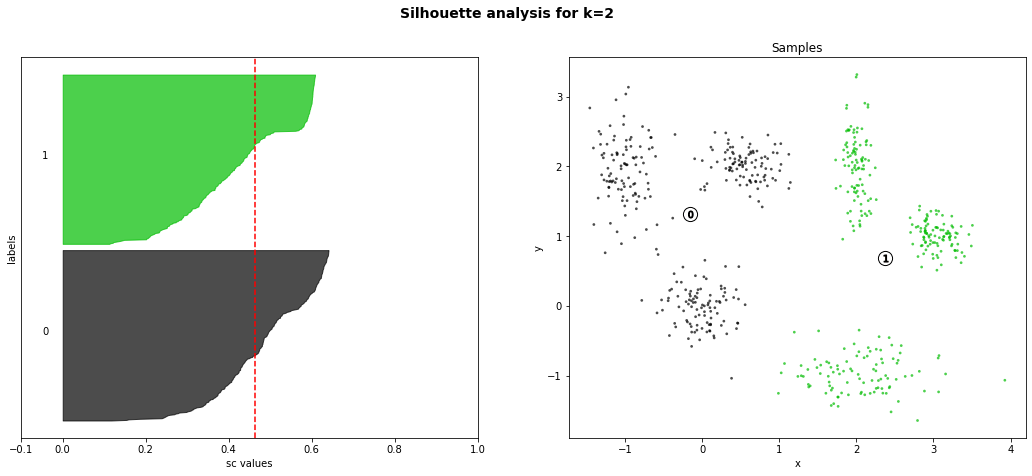

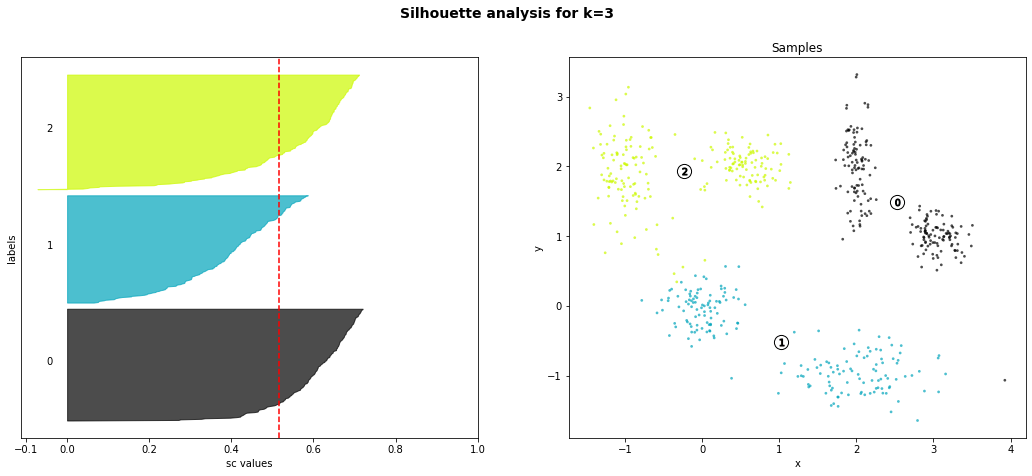

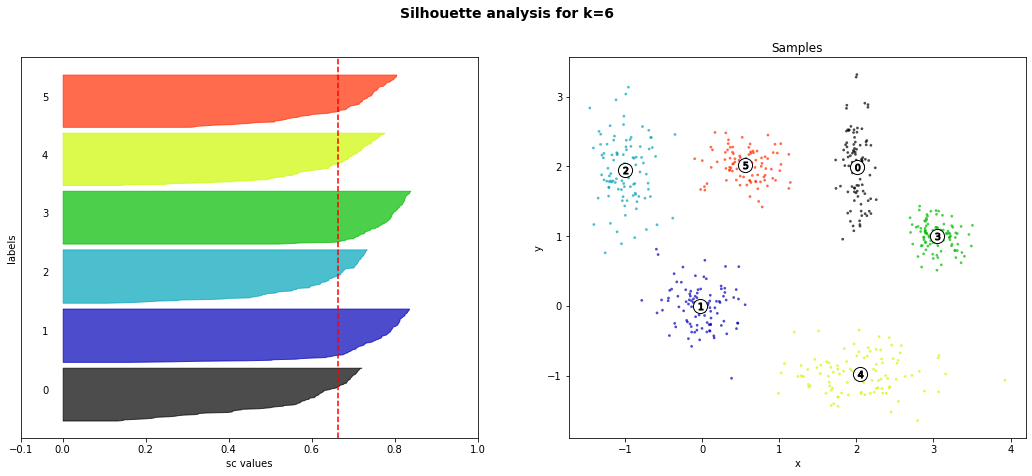

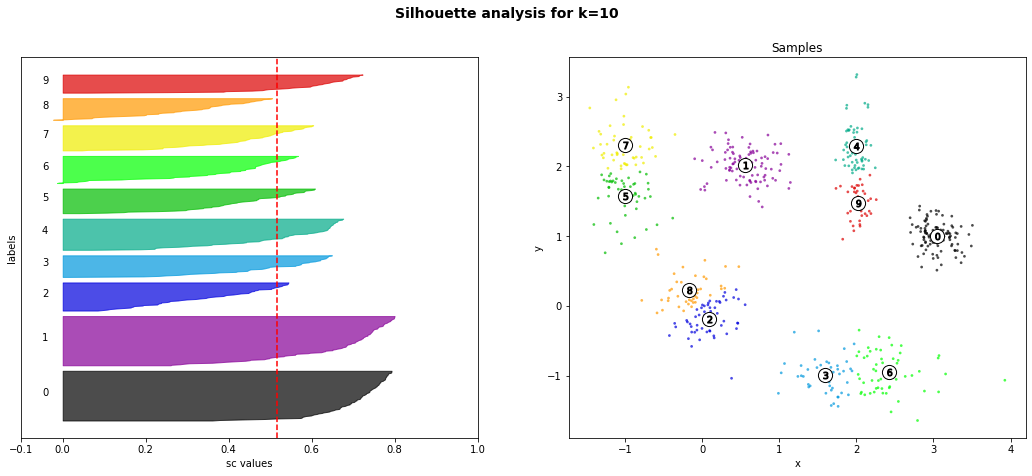

In [6]:
df = pd.read_csv("clustering.csv", header=None)
for k in [2,3,6,10]:
    estimator = KMeans(init='k-means++', n_clusters=k, n_init=10)
    labels = estimator.fit_predict(df.values)
    sc_plot(df.values, labels, estimator.cluster_centers_)

---
## **Aufgabe 3: Hierarchisches Clustering (bewertet: 2,5+0,5+0,5+1+0,5 Punkte)**

a) Berechnen Sie ein Hierarchisches Clustering aus der folgenden Distanzmatrix mit der Methode
Average Linkage von Hand. Zeichnen Sie das entsprechende Dendrogramm. 

|        | A    | B    | C     | D     |
|--------|------|------|-------|-------|
| **A**  | 0    |      |       |       |
| **B**  | 4.438|0     |       |       |
| **C**  | 3.048|6.777 |0      |       |
| **D**  | 2.259|2.887 |4.339  |0      |

###### Die minimale Distanz ist zwischen A und D:
- wähle {A,D} als neuer Cluster  und aktualisiere die Distanzmatrix:
$$
\begin{align}
d(\{A,D\},B) &= \dfrac{d(A,B) + d(D,B)}{2}
             =  \dfrac{4,438 + 2,887}{2}
             = 3,662\\
d(\{A,D\},C) &= \dfrac{d(A,C) + d(D,C)}{2} 
             =  \dfrac{3,048 + 4,339 }{2}
             = 3,693                       
\end{align}
$$



|             | {A,D}| B    | C     | 
|-------------|------|------|-------|
| **{A,D}**   | 0    |      |       |    
| **B**       | 3,662|0     |       |       
| **C**       | 3,693|6,777 |0      |  


###### Die minimale Distanz ist zwischen {A,D} und B:

- wähle {A,D,B} als neuer Cluster  und aktualisiere die Distanzmatrix:

$$
\begin{align}
d(\{A,D,B\},C) &= \dfrac{d(A,C) + d(D,C)+ d(B,C)}{3}
             =  \dfrac{3,048+ 4,339 + 6,777 }{3}
             = 4,721\\           
\end{align}
$$


|             | {A,D,B} |  C    | 
|-------------|---------|-------|
|**{A,D,B}**  | 0       |       |
| **C**       | 4,721   |0      |


###### Die minimale Distanz ist zwischen {A,D, B} und C:

- wähle {A,D,B} als neuer Cluster  und aktualisiere die Distanzmatrix:

|             | {A,D,B, C} |  
|-------------|------------|
|**{A,D,B, C}**  | 0          | 


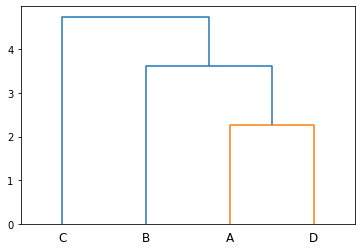

In [7]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram

linkage = np.array([[0, 3, 2.259 , 2], [1, 4, 3.613 , 3], [2, 5, 4.75 , 4]])
dendrogram(linkage, labels = ["A","B","C","D"])
plt.show()

b) Wodurch unterscheiden sich partitionierende Verfahren von den hierarchischen Verfahren?

Partitionierende Clusteringverfahren benötigen die Anzahl an Clustern als Eingabe. Außerdem arbeiten sie mit nur einem Granularitätslevel. Im Gegensatz dazu verwenden hierarchische Verfahren, wie der Name schon sagt, Hierarchien mit unterschiedlichen Granularitäten.

c) Erklären Sie *hard clustering* und *soft clustering*.

Beim *hard clustering* wird eine Instanz immer genau einem Cluster zugeordnet. Beim *soft clustering* hingegen wird die Instanz einem Cluster mit einer bestimmten Wahrscheinlichkeit zugeordnet. Die Instanz kann folglich mehreren Clustern zugeordnet sein.

d) Laden sie den Inhalt der Datei `clustering.csv`. Verwenden Sie `sklearn`, um das Average Linkage Verfahren darauf anzuwenden. Visualisieren Sie das Dendrogramm. 

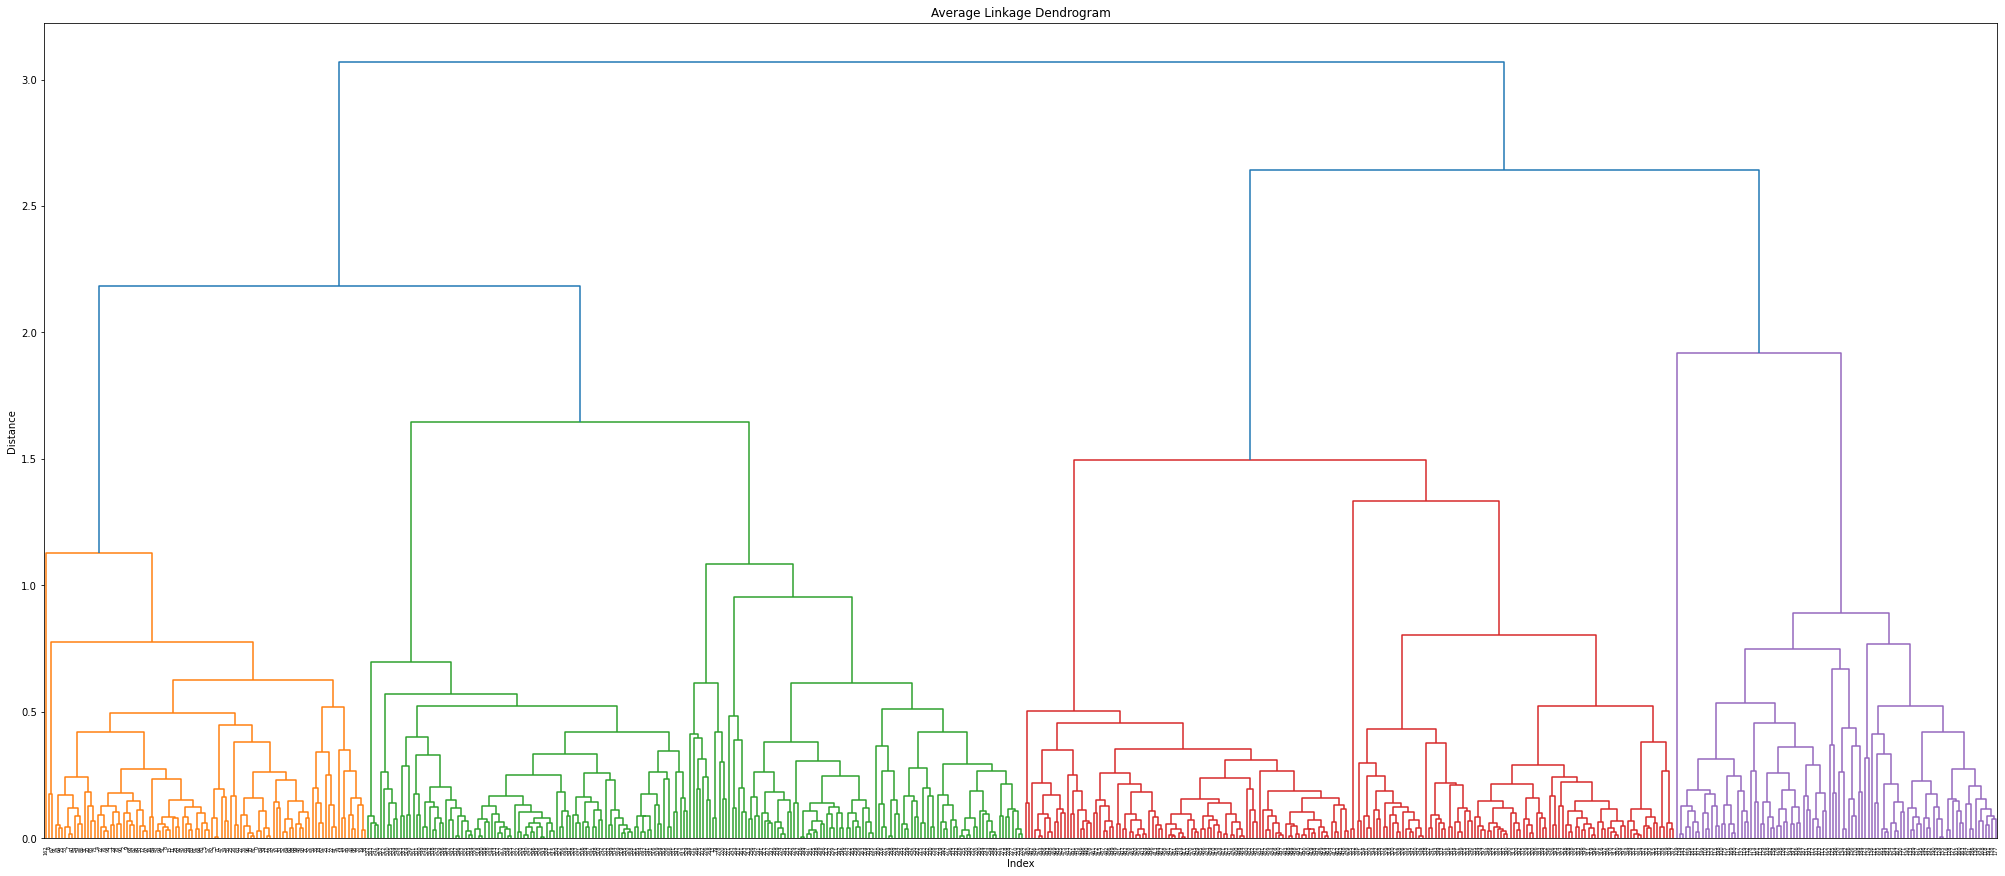

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import pandas as pd

df = pd.read_csv("clustering.csv", header=None)

points = df.values

Z = linkage(points, 'average')

plt.figure(figsize=(35, 15))
plt.title('Average Linkage Dendrogram')
plt.xlabel('Index')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90., 
    leaf_font_size=5., 
)
plt.show()

e) Verwenden Sie `sklearn`, um das Clusteringverfahren Average Linkage auf die Daten aus d) anzuwenden. Wählen Sie eine geeignte Anzahl von Clustern und visualisieren Sie das Ergebnis, sodass erkennbar ist, welcher Punkt zu welchem Cluster gehört.

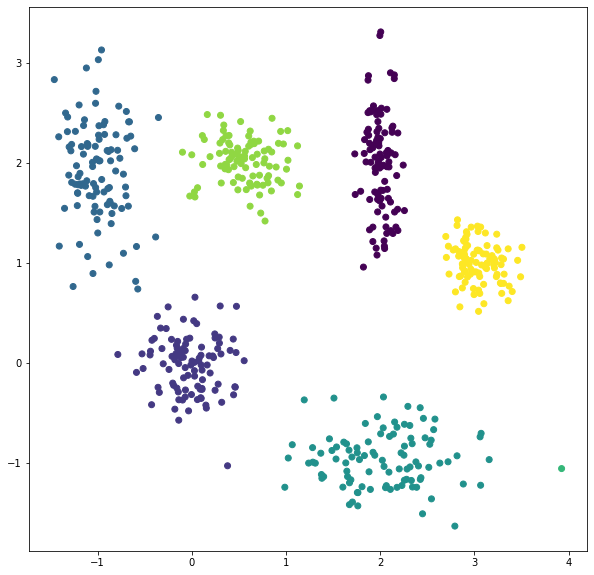

In [12]:
clustering = AgglomerativeClustering(n_clusters=7,linkage="average").fit(points)
labels = clustering.labels_

plt.figure(figsize=(10, 10))
plt.scatter(*np.array(points).T, c=labels)


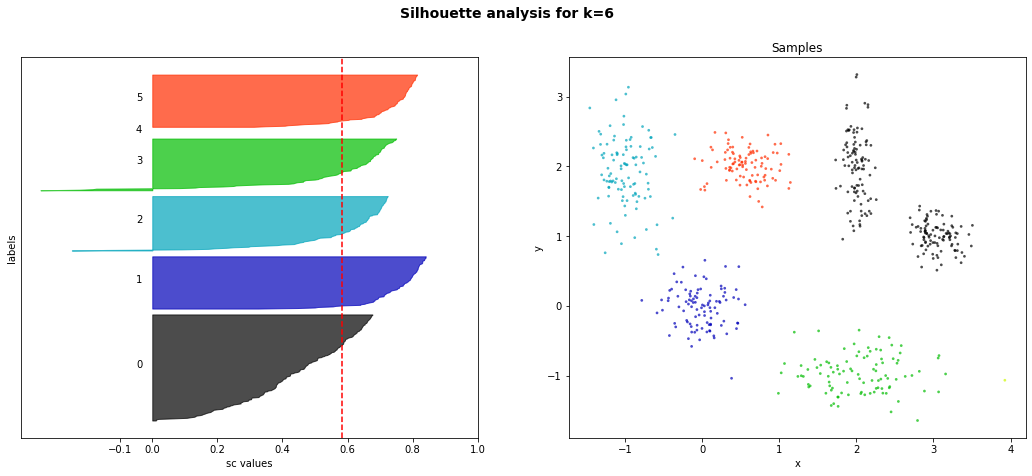

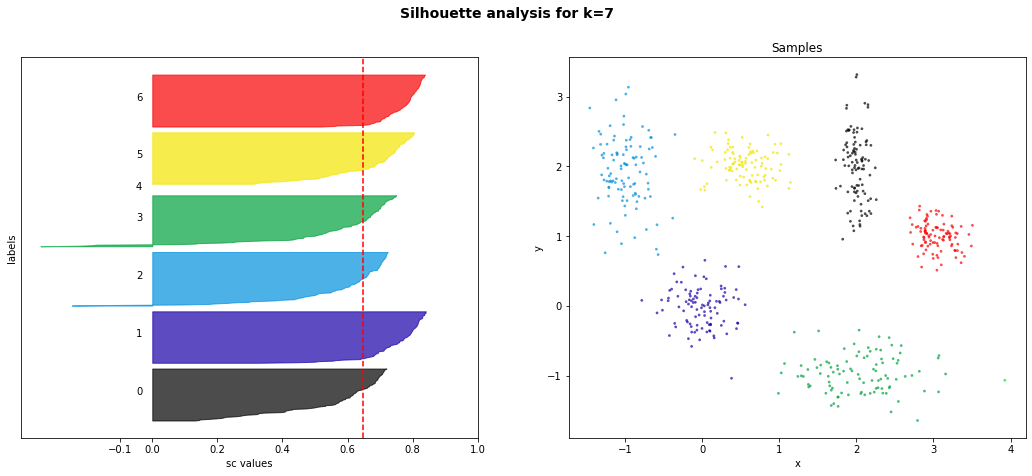

In [13]:
# Silhouette analysis (not required)

points = df.values
clustering = AgglomerativeClustering(n_clusters=6,linkage="average").fit(points)
labels = clustering.labels_

sc_plot(points, labels)

clustering = AgglomerativeClustering(n_clusters=7,linkage="average").fit(points)
labels = clustering.labels_

sc_plot(points, labels)